# Práctica 1- Árboles de decisión y Random Forest

## Machine Learning. Grado en Ciencia de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


## Introducción

Los árboles de decisión  son un método de aprendizaje supervisado no paramétrico que se utiliza para la clasificación y la regresión. El objetivo es crear un modelo que prediga el valor de una variable objetivo mediante el aprendizaje de reglas de decisión sencillas inferidas a partir de las características de los datos. La principal implementación de árboles de decisión en Python está disponible en la librería `scikit-learn` a través de las clases `DecisionTreeClassifier` y `DecisionTreeRegressor`, para los árboles de clasificación y regresión respectivamente. Esta librería necesita convertir todas las variables categóricas en variables dummy (one-hot-encoding). En otras librerías, no es necesaria dicha conversión, pero en scikit-learn, es un paso previo que debe de realizarse.  

Antes de entrar en detalle a ver como funcionan y como se configuran los árboles de decisión tanto en clasificación como en regresión, vamos a estudiar la conversión de las variables categóricas en variables dummy mediante la estrategia one-hot-encoding

## Estrategia one-hot-encoding

Las variables dummy son variables ficticias que se crean para codificar variables categóricas. Estas variables consisten en crear por cada categórica una nueva variable binaria (también llamada dummy).  Así, estas nuevas variables contendrán 1 en aquellas observaciones que pertenezcan a esa categoría y 0 en el resto. Para crear estas variables dummy se utiliza la estrategia one-hot-encoding. En phyton tenemos mucha formas de realizar esta estrategia. Vamos a ver dos formas de realizar la estrategia una utilizando la librería `Scikit-Learn` con la funcionalidad en el módulo `sklearn.preprocessing`.`OneHotEncoder()` y la otra utilizando Pandas con la función `pandas.get_dummies()`

### One-hot-encoding utilizando Pandas

A continuación se indica un ejemplo de como utilizando la función `pandas.get_dummies()`, fácilmente se convierten esas variables categóricas en variables dummy para poder ser utilizadas por las técnicas de los árboles de decisión de la librería `scikit-learn`.

In [2]:
import pandas as pd
import numpy as np


semilla=123
np.random.seed(semilla)


# Descarga de datos de la base de datos boston
# ==============================================================================
url = ( 'titanic.csv')
datos = pd.read_csv(url, sep=';')
datos.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,"22,0",1,0,"7,25",S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,"38,0",1,0,"71,2833",C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,"26,0",0,0,"7,925",S,Third,woman,False,NaN,Southampton,yes,True


Una vez cargados los datos examinamos el tipo de las variables en el dataset.

In [3]:
# Ahora identificamos para cada atributo su tipo
datos.dtypes

survived        int64
pclass          int64
sex            object
age            object
sibsp           int64
parch           int64
fare           object
embarked       object
class          object
who            object
adult_male       bool
deck           object
embark_town    object
alive          object
alone            bool
dtype: object

Como se puede ver los atributos categóricos son las correspondientes a los tipos "object" y "category". Ahora vamos a extraer estos atributos con el método `select_dtypes()` de pandas:

In [4]:
categoricas = datos.select_dtypes(include = ["object", "category"]).columns
# Mostramos las columnas extraídas
categoricas

Index(['sex', 'age', 'fare', 'embarked', 'class', 'who', 'deck', 'embark_town',
       'alive'],
      dtype='object')

Utilizamos la función `pd.get_dummies()`  en el subconjunto del dataframe datos formado por estas columnas extraídas.
En esta función utilizamos dos argumentos que son `drop_first` y `dummy_na`.

- `drop_first = True`: Este argumento permite eliminar la primera de las columnas generadas para cada característica con el objetivo de evitar la colinealidad (que una de las columnas sea combinación lineal de las demás)
- `dummy_na = True`: Este argumento permite que se genere una columna adicional para los valores nulos que se encuentren en cada característica

In [5]:
categoricas_Datos = pd.get_dummies(datos[categoricas], drop_first = True, dummy_na = True)
# Mostramos la transformación de las variables categóricas en variables dummies
categoricas_Datos.head()

,sex_male,sex_nan,"age_0,67","age_0,75","age_0,83","age_0,92","age_1,0","age_10,0","age_11,0","age_12,0",...,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,alive_yes,alive_nan
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False


Ahora eliminamos los atributos originales 

In [6]:
datos.drop(categoricas, axis = 1, inplace = True)
# Tras eliminar los atributos originales, concatenamos los nuevos atributos creados para las variables categóricas.
datos = pd.concat([datos, categoricas_Datos], axis = 1)
# Mostramos como quedan los datos de nuevo.
datos.head()

,survived,pclass,sibsp,parch,adult_male,alone,sex_male,sex_nan,"age_0,67","age_0,75",...,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,alive_yes,alive_nan
0,0,3,1,0,True,False,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1,1,1,1,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,3,0,0,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,1,1,1,0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,0,3,0,0,True,True,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False


### One-hot-encoding utilizando la funcionalidad en la clase `sklearn.preprocessing.OneHotEncoder()`

La clase `OneHotEncoder` codifica los atributos categóricos como atributos numéricos one-hot. La entrada de este transformador debe ser un *array-like* de enteros o cadenas, que denote los valores que toman las características categóricas (discretas). Las características se codifican utilizando un esquema de codificación one-hot. Esta función tiene diversos parámetros y argumentos, nosotros sólo nos centraremos en las características básicas para transformar los atributos categóricos.


Volvemos a cargar el dataset original

In [7]:
from sklearn.preprocessing import OneHotEncoder
semilla=123
np.random.seed(semilla)


# Descarga de datos de la base de datos boston
# ==============================================================================
url = ( 'titanic.csv')
datos = pd.read_csv(url, sep=';')
datos.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,"22,0",1,0,"7,25",S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,"38,0",1,0,"71,2833",C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,"26,0",0,0,"7,925",S,Third,woman,False,NaN,Southampton,yes,True


Ahora vamos a transformar el atributo `embarked` del dataset y queremos ver cuáles son sus valores únicos

In [8]:
datos.embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

Creamos una instancia del codificador para transformar las variables y utilizamos la función `fit_transform()` que ajusta los datos de entrada y los transforma. Tened en cuenta que esta función requiere una entrada de datos bidimensional.

In [9]:
codificador = OneHotEncoder()
data = codificador.fit_transform(datos.embarked.values.reshape(-1, 1))

data

<891x4 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

Como devuelve una matriz dispersa, lo que hacemos es transformarla en un array.

In [10]:
data = codificador.fit_transform(datos.embarked.values.reshape(-1, 1)).toarray()
# Mostramos el array
data

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

A través del atributo `categories_` podemos ver las categorías que se han definido.

In [11]:
codificador.categories_

[array(['C', 'Q', 'S', nan], dtype=object)]

Por último, concatenamos los nuevos datos y los mostramos. También podríamos haber borrado la columna embarked con drop


In [12]:
datos = pd.concat([
    datos.drop("embarked", axis = 1),
    pd.DataFrame(data, columns = codificador.categories_[0])
], axis = 1)
datos.head()

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,deck,embark_town,alive,alone,C,Q,S,NaN
0,0,3,male,"22,0",1,0,"7,25",Third,man,True,NaN,Southampton,no,False,0.0,0.0,1.0,0.0
1,1,1,female,"38,0",1,0,"71,2833",First,woman,False,C,Cherbourg,yes,False,1.0,0.0,0.0,0.0
2,1,3,female,"26,0",0,0,"7,925",Third,woman,False,NaN,Southampton,yes,True,0.0,0.0,1.0,0.0
3,1,1,female,"35,0",1,0,"53,1",First,woman,False,C,Southampton,yes,False,0.0,0.0,1.0,0.0
4,0,3,male,"35,0",0,0,"8,05",Third,man,True,NaN,Southampton,no,True,0.0,0.0,1.0,0.0


## Árboles de decisión para Regresión

Tras haber introducido brevemente la necesidad de transformar los atributos categóricos. Vamos a analizar como construir, entrenar y evaluar árboles de decisión para la tarea de regresión. 

Los árboles de regresión son el subtipo de árboles de predicción que se aplica cuando la variable/atributo objetivo es continuo. En términos generales, en el entrenamiento de un árbol de regresión, las instancias se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal. Cuando se quiere predecir una nueva instancia, se recorre el árbol acorde al valor de sus predictores hasta alcanzar uno de los nodos terminales. La predicción del árbol es la media de la variable respuesta de las observaciones de entrenamiento que están en ese mismo nodo terminal.

In [13]:
from sklearn.model_selection import train_test_split
# Funciones propias de lo árboles de decisión.
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/Boston.csv'
)
datos = pd.read_csv(url, sep=',')

datos.head(3)
# Mostramos el tipo de datos de los atributos por si hubiera que hacer alguna transformación
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


Ahora vamos utilizar la clase `DecisionTreeRegressor` del módulo `sklearn.tree` permite entrenar árboles de decisión para tareas de regresión. En el ejemplo que disponemos, utilizamos el atributo `MEDV`, como atributo objetivo y como predictores todas las otras variables disponibles.

La clase `DecisionTreeRegressor` tiene los siguientes hiperparámetros. Estos hiperparámetros habría que ajustarlos en función del problema a tratar.

- **criterion**: La función para medir la calidad de una separación. Los criterios soportados son **mse** para el error cuadrático medio, que es igual a la reducción de la varianza como criterio de selección de características y minimiza la pérdida L2 utilizando la media de cada nodo terminal; **friedman_mse**, que utiliza el error cuadrático medio con la puntuación de mejora de Friedman para las posibles separaciones; **mae** para el error absoluto medio, que minimiza la pérdida L1 utilizando la mediana de cada nodo terminal, y **poisson** que utiliza la reducción de la desviación de Poisson para encontrar separaciones.
- **splitter**: Indica la estrategia utilizada para elegir la separación en cada nodo. Las estrategias soportadas son **best** para elegir la mejor separación y **random** para elegir la mejor separación de forma aleatoria.
- **max_depth**:  Profundidad máxima que puede alcanzar el árbol.
- **min_samples_split**: Número mínimo de instancias que debe de tener un nodo para que pueda dividirse
- **min_samples_leaf**: Número mínimo de instancias que debe de tener cada uno de los nodos hijos para considerarse nodo hoja
- **min_weight_fraction_leaf**: La fracción ponderada mínima de la suma total de pesos (de todas las muestras de entrada) requerida para estar en un nodo hoja. Las muestras tienen el mismo peso cuando no se proporciona sample_weight.
- **max_features**: El número de características a considerar cuando se busca la mejor separación:
   - Si es **int**, entonces se consideran las características max_features en cada separación.
   - Si es **float**, entonces max_features es una fracción y las características int(max_features * n_features) se consideran en cada separación.
   - Si es **auto**, entonces `max_features=n_features`.
   - Si es **sqrt**, entonces `max_features=sqrt(n_features)`.
   - Si es **log2**, entonces `max_features=log2(n_features)`.
   - Si es **None**, entonces `max_features=n_features`.
- **random_state**: Semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.
- **max_leaf_nodes**: Número máximo de nodos hojas.
- **min_impurity_decrease**: Un nodo se dividirá si esta separación induce una disminución de la impureza mayor o igual a este valor.
- **min_impurity_split**: Umbral para la detención temprana en el crecimiento del árbol. Un nodo se separará si su impureza está por encima del umbral, de lo contrario será una hoja.
- **ccp_alpha**: Parámetro de complejidad utilizado para la Poda de Mínima Complejidad de Costes. Se elegirá el subárbol con la mayor complejidad de costes que sea menor que **ccp_alpha**. Por defecto, no se realiza ninguna poda.

Por defecto los valores de estos hiperparámetros son:
- `criterion='mse'`
- `splitter='best'`
- `max_depth=None`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
- `max_features=None`
- `random_state=None`
- `max_leaf_nodes=None`
- `min_impurity_decrease=0.0`
- `min_impurity_split=None`
- `ccp_alpha=0.0`

Para construir el árbol es necesario separar en datos de entrenamiento y de test. Los datos de entrenamiento serán los que creen y ajusten el árbol. Los datos de test son los que sirven para evaluar el modelo. La función `train_test_split()`, nos divide el conjunto de datos. Como no se explicita el valor de train y de test, por defecto el test será un 25% de los datos originales.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = semilla
                                    )

Ahora creamos el modelo y modificamos los hiperparámetros que creamos necesarios. El resto de hiperparámetros se quedarán por defecto. Una vez creado el modelo lo entrenamos a con el método `fit()`. Recordad que para entrenar el modelo sólo se utilizan los datos de train.

In [15]:
modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = semilla
          )

modelo.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=123)

Una vez creado y entrenado el árbol, podemos visualizarlo, tanto en modo gráfico como en modo texto.

Profundidad del árbol: 3
Número de nodos terminales: 8


InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object') instead.

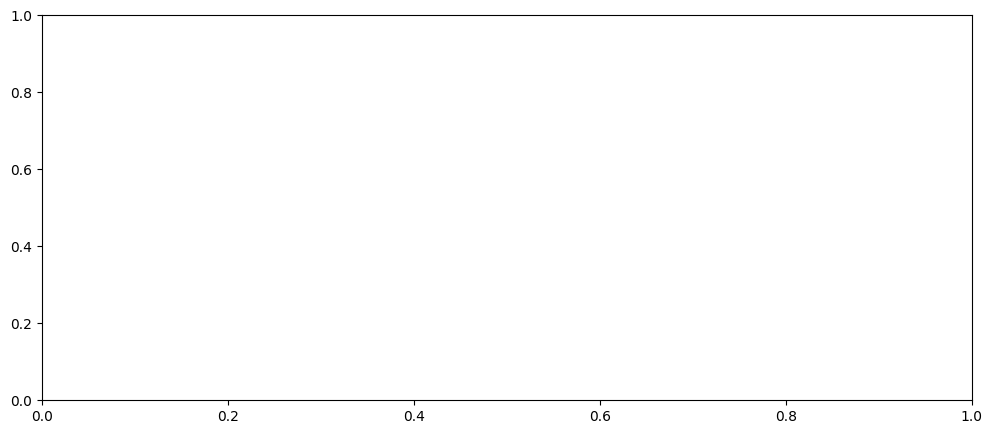

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos.drop(columns = "MEDV").columns,
            class_names   = None,
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 4,
            ax            = ax
       )

In [ ]:
texto_modelo = export_text(
                    decision_tree = modelo,
                    feature_names = list(datos.drop(columns = "MEDV").columns)
               )
print(texto_modelo)

|--- RM <= 6.98
|   |--- LSTAT <= 14.39
|   |   |--- DIS <= 1.42
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.42
|   |   |   |--- value: [23.13]
|   |--- LSTAT >  14.39
|   |   |--- CRIM <= 6.99
|   |   |   |--- value: [16.96]
|   |   |--- CRIM >  6.99
|   |   |   |--- value: [11.58]
|--- RM >  6.98
|   |--- RM <= 7.44
|   |   |--- DIS <= 1.57
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.57
|   |   |   |--- value: [32.17]
|   |--- RM >  7.44
|   |   |--- PTRATIO <= 17.90
|   |   |   |--- value: [47.36]
|   |   |--- PTRATIO >  17.90
|   |   |   |--- value: [40.12]



Una vez creado el árbol, una de las opciones que tenemos es realizar la poda. La poda nos permite reducir la varianza del modelo y así mejorar la capacidad predictiva, se somete al árbol a un proceso de *pruning*. El proceso de poda intenta encontrar el árbol más sencillo (menor tamaño) que consigue los mejores resultados de predicción.

Para aplicar el proceso de pruning es necesario indicar el parámetro **ccp_alpha**, que determina el grado de penalización por complejidad. Cuanto mayor es este valor, más agresivo el podado y menor el tamaño del árbol resultante. Dado que no hay forma de conocer de antemano el valor óptimo de **ccp_alpha**, se recurre a validación cruzada para identificarlo. Vamos a configurar un grid para obtener el mejor valor, y buscar el valor último en validación cruzada utilizando la función `GridSearchCV()`. 

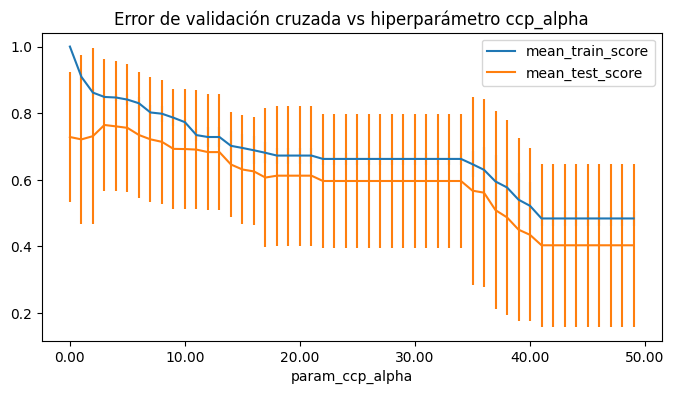

In [ ]:
from matplotlib.ticker import FormatStrFormatter
param_grid = {'ccp_alpha':np.linspace(0, 20)}


grid = GridSearchCV(
        # Configuramos el árbol para que se cree a máxima profundidad para buscar el mejor valor de poda
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = semilla
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )
# Entrenamos el grid para buscar el mejor valor.
grid.fit(X_train, y_train)
# Mostramos gráficamente todos los valores obtenidos para analizar el mejor valor de poda
fig, ax = plt.subplots(figsize=(8, 4))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Error de validación cruzada vs hiperparámetro ccp_alpha");

En el atributo `grid.best_params_` se nos indica el valor de **ccp_alpha** que produce el árbol más eficiente podemos usar

In [ ]:
print(f"El valor de ccp_alpha que genera el árbol más eficiente es {grid.best_params_}")

El valor de ccp_alpha que genera el árbol más eficiente es {'ccp_alpha': 1.2244897959183674}


También podemos ver otros parámetros como la profundidad y el número de hojas resultante a través de las correspondientes funciones. 

In [ ]:
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 4
Número de nodos terminales: 7


Una vez encontrado el mejor modelo, mostramos de nuevo el árbol resultante tras la poda. 

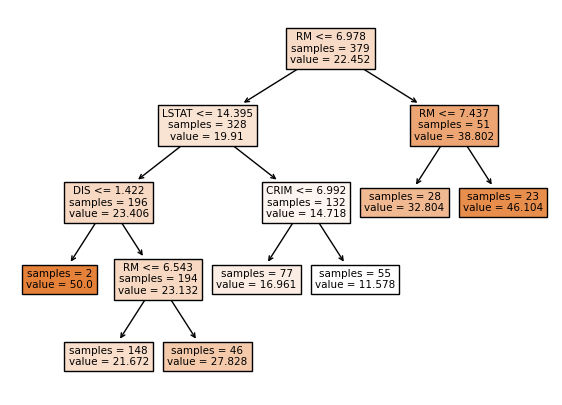

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = datos.drop(columns = "MEDV").columns,
            filled        = True,
            impurity      = False,
            ax            = ax
       )

Una vez que hemos entrenado el árbol podado pasamos a realizar la evaluación. Para comprobar la efectividad de la poda, vamos a evaluar el modelo con y sin poda.

In [ ]:
predicciones = modelo.predict(X = X_test)

rmse_sin_poda = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (rmse) de test  con el modelo sin podar es: {rmse_sin_poda:.2f}")

El error (rmse) de test  con el modelo sin podar es: 6.36


In [ ]:
predicciones = modelo_final.predict(X = X_test)

rmse_con_poda = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (rmse) de test con el modelo podado es: {rmse_con_poda:.2f}")
print(f"El modelo podado reduce el rsme en: {rmse_sin_poda-rmse_con_poda:.2f}")

El error (rmse) de test con el modelo podado es: 5.52
El modelo podado reduce el rsme en: 0.84


El proceso de poda consigue reducir el error rmse del modelo de `6.36 a 5.52. 

## Árboles de decisión para Clasificación

Los árboles de clasificación son el subtipo de árboles de predicción que se aplica cuando la variable respuesta es categórica. Veamos un ejemplo de los comandos para construir un modelo de clasificación utilizando árboles de decisión, así como sus hiperparámetros. Primero cargamos las librerías necesarias

In [ ]:
# Librerías para cargar y manipular los datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado para la construcción del árbol
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Para ilustrar los ejemplos vamos a utilizar el dataset **CASchools**, que tiene todo variables continuas menos 1 que es categórica y es la que vamos a utilizar para clasificar. Primero vamos a ver los metadatos asociados al dataset. 

In [ ]:
dataset = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = dataset.data
print(dataset.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: Carseats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   .. code:: R

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``, ``Good

Ahora inspeccionamos los datos. 

In [ ]:
datos

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


Vamos a crear una nueva variable a partir de la variable **Sales** para distinguir las ventas altas de las ventas más baja. Una vez creada la nueva variable respuesta se descarta la original.

In [ ]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
datos = datos.drop(columns = 'Sales')
datos

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,0
1,111,48,16,260,83,Good,65,10,Yes,Yes,0
2,113,35,10,269,80,Medium,59,12,Yes,Yes,0
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,1
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,Good,33,14,Yes,Yes,0
396,139,23,3,37,120,Medium,55,11,No,Yes,1
397,162,26,12,368,159,Medium,40,18,Yes,Yes,1
398,100,79,7,284,95,Bad,50,12,Yes,Yes,1


Para seguir la notación estándar en python vamos a crear los conjuntos de atributos, `X` e el vector de salida `y`

In [ ]:
X = datos.drop(columns='ventas_altas')
y = datos.ventas_altas

Ahora vamos a utilizar la clase `DecisionTreeClassifier` del módulo `sklearn.tree` que permite entrenar árboles de decisión para tareas de clasificación. En el ejemplo que disponemos, utilizamos el atributo **Ventas_Altas**, como atributo objetivo y como predictores todas las otras variables disponibles.

La clase `DecisionTreeClassifier` tiene los siguientes hiperparámetros. Estos hiperparámetros habría que ajustarlos en función del problema a tratar:

- **criterion**: La función de medir la calidad de una división, los criterios soportados son **gini** para la impureza de Gini y **entropy** para la ganancia de información.
- **splitter**:La estrategia utilizada para elegir la división en cada nodo. Las estrategias apoyadas son **best** para elegir la mejor división y **random** para elegir la mejor división aleatoria.
- **max_depth**: La profundidad máxima del árbol. 
- **min_samples_split**: El número mínimo de instancias requeridas para dividir un nodo interno
- **min_samples_leaf**: El número mínimo de instancias requeridas para estar en un nodo de hoja.
- **min_weight_fraction_leaf**: La fracción mínima ponderada de la suma total de las ponderaciones (de todas las instancias de entrada) requeridas para estar en un nodo de hoja.
- **max_features**: El número de atributos a tener en cuenta cuando se busca la mejor división:
    - Si es **int**, entonces considera las características **max_features** en cada división.
    - Si es **float**, entonces **max_features** es una fracción y las características `int(max_features * n_features)` son consideradas en cada división.
    - Si es **auto**, entonces `max_features=sqrt(n_features)`.
    - Si es **sqrt**, entonces `max_features=sqrt(n_features)`.
    - Si es **log2**, entonces `max_features=log2(n_features)`.
    - Si es **None**, entonces `max_features=n_features`.
- **random_state**: Establece la semilla para repetir los experimentos.
- **max_leaf_nodes**: Hace crecer un árbol con max_leaf_nodes en modo *best-first*. Los mejores nodos se definen como una reducción relativa de la impureza. Si es **None**, el número de nodos hoja es ilimitado.
- **min_impurity_decrease**: Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor.
- **ccp_alpha**: Parámetro de complejidad utilizado para la Poda de Mínima Complejidad de Costo. El subárbol con la complejidad de costo mayor que sea menor que ccp_alpha será elegido. 

Los hiperparámetros por defecto si no se especifican toman los siguientes valores:
- `criterion=gini`
- `splitter=best`
- `max_depth=None`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
-  `max_features=None`
-  `random_state=None`
-  `max_leaf_nodes=None`
-  `min_impurity_decrease=0.0`
-  `ccp_alpha=0`

Una vez cargado el dataset, lo siguiente es dividir el conjunto de datos en las particiones de train y el test y transformar las variables categóricas.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = semilla)

Antes de ajustar el modelo es necesario transformar las variables categóricas en numéricas. Para ellos vamos a utilizar el One-hot encoding.  Primero identificamos las variables numéricas y categóricas. 

In [ ]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

 Ahora podemos aplicar el one-hot-encoding solo a las columnas categóricas. Aquí veremos otra forma de hacerlo utilizando OneHotEncoder y ColumnTransformer. Con el parámetro `handle_unknown=ignore` lo que hacemos es que cuando se encuentra una categoría desconocida durante la transformación, las columnas codificadas resultantes para esta característica serán todas ceros. El parámetro `remainder='passthrough'` de la clase `ColumnTransformer` nos permite que las columnas que no se van a transformar pasen automáticamente al dataset resultante.

In [ ]:
preprocesar = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

Una vez que se ha definido el objeto ColumnTransformer, con el método `fit()` se aprenden las transformaciones con los datos de entrenamiento y se aplican a los dos conjuntos a través de la función  `transform()`. Ambas operaciones se pueden realizar a la vez con con `fit_transform()`.

In [ ]:
X_train_prep = preprocesar.fit_transform(X_train)
X_test_prep  = preprocesar.transform(X_test)

El resultado obtenido al realizar el preprocesamiento es un `numpy array`, por lo que se pierden los nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético. En la siguiente celda se puede ver cómo volvemos a convertir la salida del `ColumnTransformer` en dataframe y añadir el nombre de las columnas

In [ ]:
# Nombre de todas las columnas
encoded_cat = preprocesar.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


Una vez que el dataset está preparado ya podemos proceder con la creación del modelo, así como el ajuste del valor de poda y su evaluación. 

In [ ]:
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = semilla
          )

modelo.fit(X_train_prep, y_train)
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

Profundidad del árbol: 5
Número de nodos terminales: 23


Ahora visualizamos el árbol. 

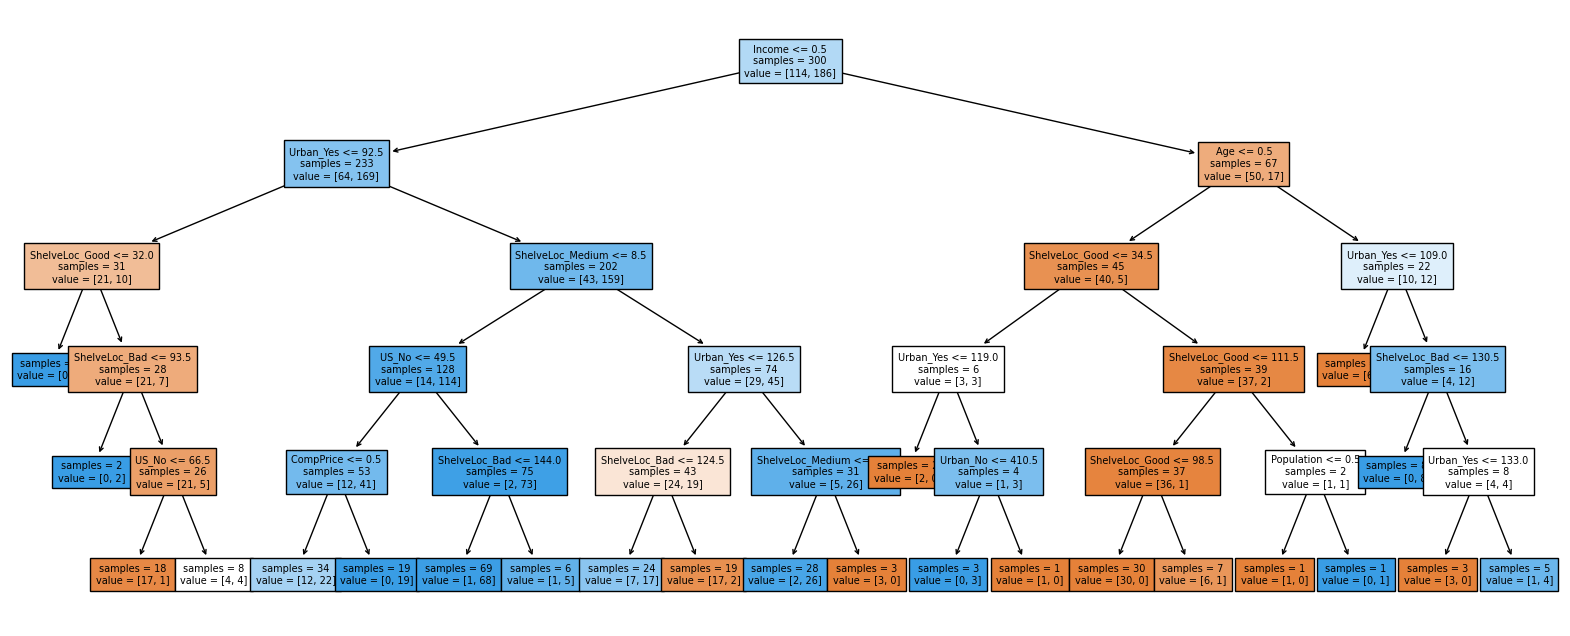

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

Ahora pasamos a evaluar el modelo en el conjunto de test sin realizar ninguna poda.

In [ ]:
predicciones_test = modelo.predict(X = X_test_prep,)
print("Matriz de confusión")
print("-------------------")
print(confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones_test
))
# Calculamos el accuracy
accuracy_test = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones_test,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy_test} %")

Matriz de confusión
-------------------
[[29 21]
 [ 7 43]]
El accuracy de test es: 72.0 %


Para poder comparar y ver que nuestro modelo no ha sufrido sobreajuste (overfitting), vamos a realizar un grid para encontrar el mejor valor para realizar la poda a través del hiperparámetro **ccp_alpha**.

In [ ]:
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Realizamos la búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = semilla
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )



In [ ]:
# Entrenamos el Grid
grid.fit(X_train_prep, y_train)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])},
             return_train_score=True, scoring='accuracy')

El valor de **cc_alpha** que da el mejor árbol es

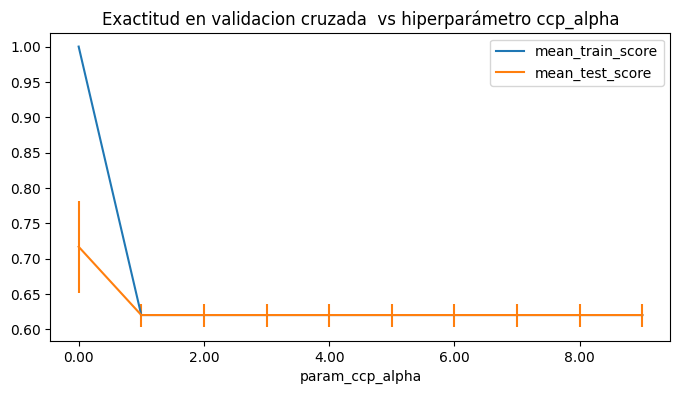

In [ ]:
# Mostramos los resultados
fig, ax = plt.subplots(figsize=(8, 4))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("Exactitud en validacion cruzada  vs hiperparámetro ccp_alpha");

In [ ]:
print(f"El valor de ccp_alpha que genera el árbol más eficiente es {grid.best_params_}")

El valor de ccp_alpha que genera el árbol más eficiente es {'ccp_alpha': 0.0}


Ahora ya podemos quedarnos con el mejor modelo. 

In [ ]:
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 9
Número de nodos terminales: 49


Ya sólo nos queda evaluar el árbol obtenido en el conjunto de test. 

In [ ]:
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test una vez realizada la poda es: {100 * accuracy} %")

El accuracy de test una vez realizada la poda es: 75.0 %


Gracias al proceso de poda se ha conseguido un árbol más general, consiguiendo una pequeña mejora en el accuracy, ya que emos pasado de un 72% a un 75%.

### Predicción de probabilidades 

La mayoría de implementaciones de los modelos basados en árboles, y entre ellas la de `scikit-learn`, permiten predecir las probabilidades de pertencia a cada clase cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

En el ejemplo anterior, el  método `.predict()`  devuelve un 1 ventas elevadas) o un0 (ventas bajas) para cada observación del conjunto de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con `.predict_proba()`, en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases. Asi, se pueden realizar clasificaciones atendiendo a otros criterios y no siempre a la clase mayoritaria.

Para predecir las probabilidades debemos utilizar el método `.predict_proba()`. 

In [ ]:
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [0.89473684, 0.10526316],
       [0.94444444, 0.05555556],
       [0.89473684, 0.10526316]])

Ahora podemos definir un criterio propio para la asignación de las instancias a clases a partir de las probabilidades. Por ejemplo, si queremos asignar a cada instancia a la clase con mayor probabilidad, podemos utilizar el siguiente código. 

In [ ]:
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,1.000000,0.000000,0
1,0.000000,1.000000,1
2,0.894737,0.105263,0


Si queremos redefinir el criterio de asignación de clases, empleando un umbral de 0.7 para la clase 1 (podemos definir el umbral que queramos) podríamos hacerlo de la siguiente manera. 

In [ ]:
df_predicciones['clasificacion_custom_0.7'] = np.where(df_predicciones['1'] > 0.7, 1, 0)
df_predicciones.iloc[5:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.7
5,0.500000,0.500000,1,0
6,0.071429,0.928571,1,1
7,0.944444,0.055556,0,0
8,0.014493,0.985507,1,1
9,0.291667,0.708333,1,1


## Ensamble Random Forest

**Random Forest** es un ensamble (combinación de modelos, en este caso árboles) que se puede utilizar tanto en la tarea de clasificación como en la de regresión. Esta técnica toma como base un árbol de decisión y forma un ensamble al crear tantos árboles como indique uno de sus parámetros. Random Forest utiliza varias submuestras del conjunto de datos  y un subconjunto de los atributos para construir cada árbol. Después utiliza el promedio de las predicciones de cada uno de los árboles para mejorar la precisión predictiva y controlar el sobreajuste. El tamaño de la submuestra se controla con el parámetro **max_samples** si `bootstrap=True` (predeterminado), de lo contrario se utiliza todo el conjunto de datos para construir cada árbol. 

### Random Forest para Regresión

Vamos a ver un ejemplo de la aplicación de Random Forest para regresión con la base de datos **Boston**. Pero antes, debemos de comentar los hiperparámetros a configurar. Hay que tener en cuenta que se utilizan los mismos hiperparámetros que hemos visto para el árbol de regresión, pero además se incluyen los siguientes que son específicos de la configuración de Random Forest:
- **n_estimators**: Número de árboles que componen el ensamble.
- **bootstrapb**: Si se utiliza el bootstrap para construir cada uno de los árboles. Si se pone a False, se utiliza todo el conjunto de datos. 
- **oob_scoreb**: Si se utilizan instancias de **out-of-bag** para estimar la puntuación. Por defecto, se utiliza **r2_score**, aunque se puede configurar. Esta opción está disponible si `bootstrap=True`.
- **n_jobs**:  Número de trabajos en paralelo. Si se pone -1 se utilizan todos los procesadores disponibles. 
- **verbose**: Controla si se muestra el ajuste y las predicciones durante el proceso de construcción del modelo. 
- **warm_start**: Si se establece en `True`, se reutiliza la solución de la llamada anterior al ajuste y se añaden más estimadores al conjunto; de lo contrario, se ajusta un ensamble completamente nuevo.

De estos parámetros, las opciones por defecto son:
- `n_estimatorsint=100`
- `bootstrap=True`
- `oob_score=False`
- `n_jobs=None`
- `verbose=0`
- `warm_start= False`

Lo primero que vamos a hacer es cargar el dataset que vamos a utilizar de ejemplo para después proseguir con la construcción del Random Forest. 

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance


# Descarga de datos de la base de datos boston
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/Boston.csv'
)
datos = pd.read_csv(url, sep=',')
datos.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7


Recordad que también es conveniente examinar la estructura del dataset

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


Vemos que todos las variables son numéricas. En nuestro problema vamos a utilizar la variable **MEDV** como variable objetivo a predecir. Como venimos haciendo hasta ahora, el primer paso es la partición del data set en los conjuntos de entrenamiento y test. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = semilla
                                    )

Ahora procedemos la construcción del modelo con el conjunto de train. Inicialmente vamos a crear un modelo básico que intentaremos mejorar.  

In [ ]:
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = semilla
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse_test = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
       )
print(f"El error (rmse) de test es: {rmse_test:.4f}")

El error (rmse) de test es: 4.1780


### Optimización de hiperparámetros - búsqueda GRID

Aunque se puede realizar un análisis individual y un Grid de parámetros para cada uno de los parámetros de Random Forest, mejor realizar una búsqueda de varios parámetros de forma simultánea. Para ello es preferible recurrir a un **grid search** o **random search** para analizar varias combinaciones de hiperparámetros. En este caso vamos a realizar una búsqueda de hiperparámetros para el número de árboles, la profundidad máxima y el número de atributos/variables. Esta búsqueda de parámetros se puede hacer tanto para clasificación como para regresión, la diferencia está en cambiar el modelo que se utiliza de base y los parámetros si es que son diferentes los que se pretenden ajustar.

Primero creamos el Grid con los hiperparámetros que queremos evaluar, con lo que tenemos que especificar el rango de búsqueda de cada uno de los  hiperparámetros. 

In [ ]:
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

Una vez definido el GRID ahora podemos hacer un bucle para recorrer todo el grid y entrenar un Random Forest para cada combinación de hiperparámetros en el GRID. 

In [ ]:
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = semilla,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓


Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


Una vez recorrido todo el GRID, procedemos a mostrar los resultados. 

In [ ]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

,oob_r2,max_depth,max_features,n_estimators
6,0.882461,10.0,5.0,150.0
0,0.875289,NaN,5.0,150.0
9,0.874590,20.0,5.0,150.0
10,0.874318,20.0,7.0,150.0


Evidentemente, también se puede realizar el Grid basado en validación cruzada, igual que se ha realizado anteriormente para buscar el mejor valor para realizar la poda.

### Ejercicios

1. Utiliza el conjunto de datos de Iris y crea un árbol para predecir la clase de las flores. Recuerda establecer la semilla y el random_state (por ejemplo 123)

   1.1 Crea un árbol de clasificación utilizando un hold out (70-30). Calcula todas las métricas que conozcas, incluyendo la curva ROC y el AUC, tanto para el train como para el test.

   1.2 Dibuja el árbol que se ha creado con el 70% de los datos. Calcula el mejor valor de poda. ¿Qué conclusión se obtiene?

   1.3 Crea una validación cruzada de 5 fold con un árbol de clasificación, utilizando como métrica "accuracy".

   1.4 Compara los resultados en accuracy obtenidos en el 1.1 y en el ejercicio 1.3, ¿qué se puede concluir?
   
   1.5 ¿Cuáles son los hiperparámetros del árbol que has considerado? Calcula un grid de parámetros para verificar si es mejor utilizar el indice de Gini o la ganancia de información o establecer un máximo de profundidad.
 
Notas: Para el cálcula de las métricas, como ahora tenemos 3 clases, hay que incluir en precision_score, recall_score y f1_score, el parámetro average=None, para que no devuelva una media sino el valor para cada una de las clases. Estas funciones sólo funcionan para tarjet binarios sin ese parámetro.


2. Utiliza de nuevo el conjunto de datos de Iris, pero esta vez utiliza un modelo de Random Forest. Crea ensamble con un hold-out de 70-30 y calcula las métricas. Dibuja dos árboles de los que crea el modelo.

   2.1 Haz un grid para averiguar los mejores parámetros, investiga y utiliza la búsqueda de parámetros aleatoria. Incluye los parámetros que creas más relevantes. ¿Cuáles son los mejores hiperparámetros? ¿Con qué modelo obtienes mejores resultados, con el árbol de decisión o con el Random Forest?
  


3. Carga el conjunto de datos de 'Concrete_Data.csv' proporcionado junto con este notebook. Antes de crear ningún modelo, analiza los datos y observa si hay que hacer alguna transformación en ellos. 
   
    3.1 Crea un árbol de regresión para predecir la variable 'Concrete_ compressive' utiliando un hold-out 70-30. Recuerda indicar la semilla y pon profundidad máxima. Además, verifica si es necesario hacer poda y cuál sería el mejor parámetros para realizarla. Dibuja el árbol creado sin poda y con poda si esta fuera necesaria.



4. Utiliza de nuevo el conjunto de datos de 'Concrete_Data.csv' pero esta vez crea un modelo con el ensamble Random Forest con el mismo hold-out 70-30. ¿Cuáles son los mejores hiperparámetros? Realiza una comparativa de los resultados de Random Forest con el árbol de decisión.